In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose,LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img

In [2]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
def define_discriminator(image_shape,learning_rate=0.0002):

    init=RandomNormal(stddev=0.02,seed=1)

    in_src_image=Input(shape=image_shape)
    in_target_image=Input(shape=image_shape)

    merged=Concatenate()([in_src_image,in_target_image])

    d=Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(merged)
    d=LeakyReLU(alpha=0.2)(d)

    d=Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
    d=BatchNormalization()(d)
    d=LeakyReLU(alpha=0.2)(d)
    
    d=Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
    d=BatchNormalization()(d)
    d=LeakyReLU(alpha=0.2)(d)

    d=Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
    d=BatchNormalization()(d)
    d=LeakyReLU(alpha=0.2)(d)

    d=Conv2D(512,(4,4),padding='same',kernel_initializer=init)(d)
    d=BatchNormalization()(d)
    d=LeakyReLU(alpha=0.2)(d)

    d=Conv2D(1,(4,4),padding='same',kernel_initializer=init)(d)
    patch_out=Activation('sigmoid')(d)

    model=Model(inputs=[in_src_image,in_target_image],outputs=patch_out)

    opt=Adam(learning_rate=learning_rate,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt,loss_weights=[0.5])
    return model

In [4]:
def define_encoder_block(layer_in,n_filters,batchnorm=True):
    
    init=RandomNormal(stddev=0.02,seed=1)

    g=Conv2D(n_filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(layer_in)
    if batchnorm:
        g=BatchNormalization()(g,training=True)
    g=LeakyReLU(alpha=0.2)(g)
    
    return g

In [5]:
def define_decoder_block(layer_in,skip_in,n_filters,dropout=True):
    
    init=RandomNormal(stddev=0.02,seed=1)

    g=Conv2DTranspose(n_filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(layer_in)
    g=BatchNormalization()(g,training=True)
    if dropout:
        g=Dropout(0.5)(g,training=True)
    g=Concatenate()([g,skip_in])
    g=Activation('relu')(g)

    return g

In [6]:
def define_generator(image_shape=(256,256,3)):

    init=RandomNormal(stddev=0.02,seed=1)

    in_image=Input(shape=image_shape)

    e1=define_encoder_block(in_image,64,batchnorm=False)
    e2=define_encoder_block(e1,128)
    e3=define_encoder_block(e2,256)
    e4=define_encoder_block(e3,512)
    e5=define_encoder_block(e4,512)
    e6=define_encoder_block(e5,512)
    e7=define_encoder_block(e6,512)

    b=Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(e7)
    b=Activation('relu')(b)

    d1=define_decoder_block(b,e7,512)
    d2=define_decoder_block(d1,e6,512)
    d3=define_decoder_block(d2,e5,512)
    d4=define_decoder_block(d3,e4,512,dropout=False)
    d5=define_decoder_block(d4,e3,256,dropout=False)
    d6=define_decoder_block(d5,e2,128,dropout=False)
    d7=define_decoder_block(d6,e1,64,dropout=False)

    g=Conv2DTranspose(image_shape[2],(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d7)
    out_image=Activation('tanh')(g)

    model=Model(in_image,out_image)
    return model

In [7]:
def define_gan(g_model,d_model,image_shape):
    
    for layer in d_model.layers:
        if not isinstance(layer,BatchNormalization):
            layer.trainable=False
    
    in_src=Input(shape=image_shape)

    gen_out=g_model(in_src)

    dis_out=d_model([in_src,gen_out])

    model=Model(in_src,[dis_out,gen_out])

    opt=Adam(learning_rate=0.0002,beta_1=0.5)

    model.compile(loss=['binary_crossentropy','mae'],
                  optimizer=opt,loss_weights=[1,100])
    return model

In [8]:
def generate_real_samples(n_sample,patch_shape,path_in='./processed_dataset/image_gan_in_final/',path_out='./processed_dataset/image_gan_out_final/',test=False):

    start=0
    end=70001
    if (test):
        start=70001
        end=80788
    ix=np.random.randint(start,end,n_sample)

    X1,X2=list(),list()
    
    for i in ix:
        pixels_in=load_img(path_in+f"{i}.png")
        pixels_in=np.array(pixels_in)
        pixels_in=pixels_in/255.0
        X1.append(pixels_in)
        pixels_out=load_img(path_out+f"{i}.png")
        pixels_out=np.array(pixels_out)
        pixels_out=pixels_out/255.0
        X2.append(pixels_out)

    y=np.ones((n_sample,patch_shape,patch_shape,1))

    if test:
        return [np.array(X1),np.array(X2)],y,ix
        
    return [np.array(X1),np.array(X2)],y

In [9]:
def generate_fake_samples(g_model,samples,patch_shape):

    X=g_model.predict(samples)

    y=np.zeros((len(X),patch_shape,patch_shape,1))

    return X,y

In [10]:
def summarize_performance(step,g_model,d_model,gan_model,n_sample=3,path_in='./processed_dataset/image_gan_in_final/',path_out='./processed_dataset/image_gan_out_final/'):
    
    [X_realA,X_realB],y=generate_real_samples(n_sample,1,path_in,path_out)

    X_fakeB,_=generate_fake_samples(g_model,X_realA,1)

    for i in range(n_sample):
        plt.subplot(3,n_sample,1+i)
        plt.axis('off')
        plt.imshow(X_realA[i])

    for i in range(n_sample):
        plt.subplot(3,n_sample,1+n_sample+i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])

    for i in range(n_sample):
        plt.subplot(3,n_sample,1+n_sample*2+i)
        plt.axis('off')
        plt.imshow(X_realB[i])

    filename1='./gan_results/plots/plot_%06d.png'%(step+1)
    plt.savefig(filename1)
    plt.close()

    filename2='./gan_results/g_models/g_model_%06d.h5'%(step+1)
    g_model.save(filename2)

    filename3='./gan_results/d_models/d_model_%06d.h5'%(step+1)
    d_model.save(filename3)

    filename4='./gan_results/gan_models/gan_model_%06d.h5'%(step+1)
    gan_model.save(filename4)

    print('>Saved: %s and %s,%s,%s'%(filename1,filename2,filename3,filename4))

In [11]:
def train(d_model,g_model,gan_model,n_epochs=100,n_batch=1,current_iter=0):
    
    n_patch=d_model.output_shape[1]
    bat_per_epo=int(70001/n_batch)
    n_steps=bat_per_epo*n_epochs

    for i in range(current_iter,n_steps):

        [X_realA,X_realB],y_real=generate_real_samples(n_batch,n_patch)
        X_fakeB,y_fake=generate_fake_samples(g_model,X_realA,n_patch)

        real_noise=0.5*tf.random.normal(tf.shape(y_real))-0.3
        fake_noise=0.3*tf.random.normal(tf.shape(y_fake))

        y_real-=real_noise
        y_fake+=fake_noise

        d_loss1=d_model.train_on_batch([X_realA,X_realB],y_real)
        d_loss2=d_model.train_on_batch([X_realA,X_fakeB],y_fake)

        g_loss,_,_=gan_model.train_on_batch(X_realA,[y_real,X_realB])

        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]'%(i+1,d_loss1,d_loss2,g_loss))

        if ((i+1)%int(1000/n_batch)==0):
            summarize_performance(i,g_model,d_model,gan_model)

In [21]:
path_in='./processed_dataset/image_gan_in_final/'
path_out='./processed_dataset/image_gan_out_final/'

[src_images,tar_images],_,ix=generate_real_samples(10,1,test=True)
print('Loaded: ',src_images.shape,tar_images.shape)

Loaded:  (10, 256, 256, 3) (10, 256, 256, 3)


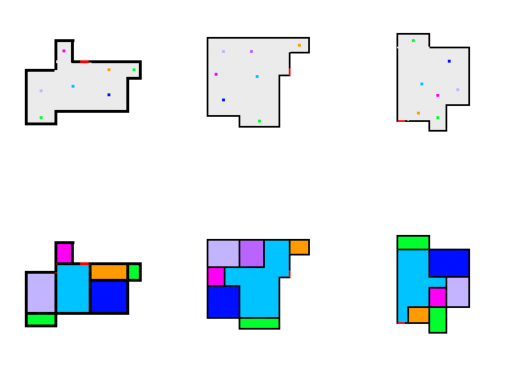

In [22]:
n_samples=3
for i in range(n_samples):
    plt.subplot(2,n_samples,i+1)
    plt.axis('off')
    plt.imshow(src_images[i])
for i in range(n_samples):
    plt.subplot(2,n_samples,1+n_samples+i)
    plt.axis('off')
    plt.imshow(tar_images[i])
plt.show()

In [14]:
d_model=define_discriminator((256,256,3),0.00001)
g_model=define_generator((256,256,3))

gan_model=define_gan(g_model,d_model,(256,256,3))

In [15]:
#trainset=0-70000
#testset=70001-80787

In [32]:
tf.keras.backend.set_value(d_model.optimizer.learning_rate,0.00005)

In [41]:
from datetime import datetime
start=datetime.now()

train(d_model,g_model,gan_model,n_epochs=1,n_batch=1,current_iter=52000)

stop=datetime.now()

1/1 [==============================] - 0s 44ms/step
>52001, d1[0.214] d2[0.534] g[1.010]
1/1 [==============================] - 0s 40ms/step
>52002, d1[0.257] d2[0.488] g[2.190]
1/1 [==============================] - 0s 38ms/step
>52003, d1[0.268] d2[0.463] g[2.049]
1/1 [==============================] - 0s 49ms/step
>52004, d1[0.276] d2[0.447] g[1.320]
1/1 [==============================] - 0s 47ms/step
>52005, d1[0.282] d2[0.437] g[1.153]
1/1 [==============================] - 0s 38ms/step
>52006, d1[0.289] d2[0.428] g[1.507]
1/1 [==============================] - 0s 30ms/step
>52007, d1[0.297] d2[0.417] g[1.294]
1/1 [==============================] - 0s 32ms/step
>52008, d1[0.305] d2[0.408] g[1.418]
1/1 [==============================] - 0s 37ms/step
>52009, d1[0.310] d2[0.402] g[1.169]
1/1 [==============================] - 0s 40ms/step
>52010, d1[0.314] d2[0.397] g[2.258]
1/1 [==============================] - 0s 41ms/step
>52011, d1[0.318] d2[0.393] g[2.177]
1/1 [================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: ./gan_results/plots/plot_053000.png and ./gan_results/g_models/g_model_053000.h5,./gan_results/d_models/d_model_053000.h5,./gan_results/gan_models/gan_model_053000.h5
1/1 [==============================] - 0s 67ms/step
>53001, d1[0.334] d2[0.349] g[1.278]
1/1 [==============================] - 0s 50ms/step
>53002, d1[0.333] d2[0.352] g[1.573]
1/1 [==============================] - 0s 40ms/step
>53003, d1[0.363] d2[0.338] g[1.364]
1/1 [==============================] - 0s 54ms/step
>53004, d1[0.362] d2[0.338] g[2.037]
1/1 [==============================] - 0s 47ms/step
>53005, d1[0.356] d2[0.343] g[1.556]
1/1 [==============================] - 0s 62ms/step
>53006, d1[0.353] d2[0.341] g[1.659]
1/1 [==============================] - 0s 48ms/step
>53007, d1[0.345] d2[0.361] g[1.469]
1/1 [==============================] - 0s 62ms/step
>53008, d1[0.352] d2[0.339] g[1.418]
1/1 [==============================] - 0s 68ms/step
>53009, d1[0.344] d2[0.338] g[1.601]
1/1 [===================

KeyboardInterrupt: 

In [46]:
d_model.load_weights(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\gan_results\d_models\d_model_052000.h5")

In [171]:
d_model.save_weights(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\gan_results\d_models\d_model_temp.h5")

In [15]:
g_model.load_weights(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\gan_results\g_models\g_model_052000.h5")

In [172]:
g_model.save_weights(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\gan_results\g_models\g_model_temp.h5")

In [48]:
gan_model.load_weights(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\gan_results\gan_models\gan_model_052000.h5")

In [173]:
gan_model.save_weights(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\gan_results\gan_models\gan_model_temp.h5")

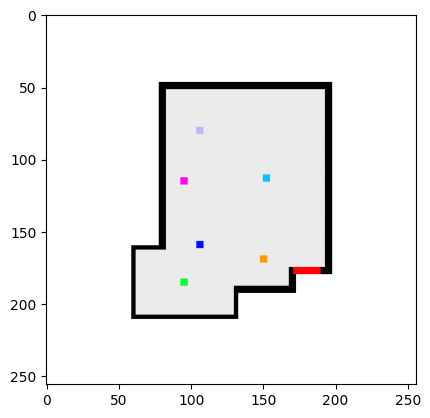

In [25]:
plt.imshow(src_images[4])

In [26]:
res=g_model.predict(src_images)

1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


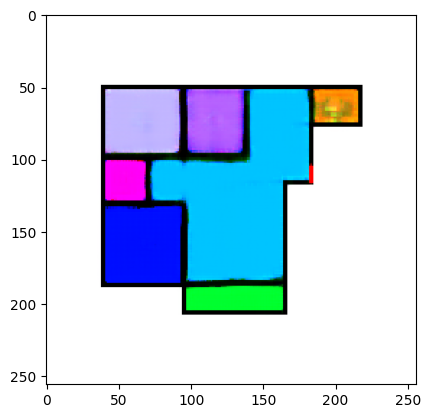

In [29]:
plt.imshow(res[1])

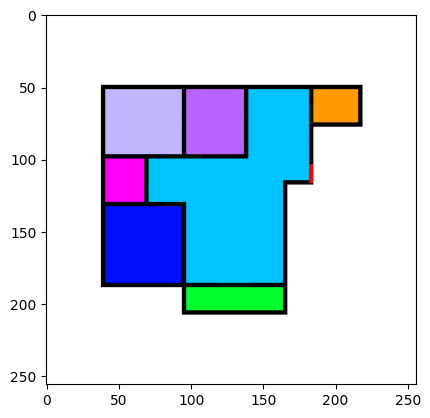

In [34]:
plt.imshow(tar_images[1])

In [31]:
print(ix)

[79714 71847 77078 74929 75812 75213 79704 78697 76526 72036]
